## Decision tree from scratch

In [263]:
from __future__ import division, print_function
import numpy as np
import math

class DecisionNode():
    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i          
        self.threshold = threshold  
        self.value = value              
        self.true_branch = true_branch      
        self.false_branch = false_branch    


class DecisionTree(object):
    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None): #
        self.root = None
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self._impurity_calculation = None
        self._leaf_value_calculation = None
        self.one_dim = None
        self.loss = loss

    def fit(self, X, y, loss=None):
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss=None
    
    def _split_on_feature(self, X, feature_i, threshold):
        split_func = lambda sample: sample[feature_i] >= threshold
        X_1 = np.array([sample for sample in X if split_func(sample)])
        X_2 = np.array([sample for sample in X if not split_func(sample)])
        return np.array([X_1, X_2])
    
    def _build_tree(self, X, y, current_depth=0):
        largest_impurity = 0
        best_criteria = None    
        best_sets = None        

        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        Xy = np.concatenate((X, y), axis=1)
        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                for threshold in unique_values:
                    Xy1, Xy2 = self._split_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        impurity = self._impurity_calculation(y, y1, y2)

                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],   
                                "lefty": Xy1[:, n_features:],   
                                "rightX": Xy2[:, :n_features],  
                                "righty": Xy2[:, n_features:] 
                                }

        if largest_impurity > self.min_impurity:
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                                "threshold"], true_branch=true_branch, false_branch=false_branch)

        leaf_value = self._leaf_value_calculation(y)
        return DecisionNode(value=leaf_value)
    
    
    def predict_value(self, x, tree=None):
        if tree is None:
            tree = self.root

        if tree.value is not None:
            return tree.value

        feature_value = x[tree.feature_i]
        branch = tree.false_branch
        if feature_value >= tree.threshold:
            branch = tree.true_branch

        return self.predict_value(x, branch)

    def predict(self, X):
        y_pred = [self.predict_value(sample) for sample in X]
        return np.array(y_pred)

    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root

        if tree.value is not None:
            print (tree.value)

        else:
            print ("%s:%s? " % (tree.feature_i, tree.threshold))
            print ("%sT->" % (indent), end="")
            self.print_tree(tree.true_branch, indent + indent)
            print ("%sF->" % (indent), end="")
            self.print_tree(tree.false_branch, indent + indent)
            
            
class ClassificationTree(DecisionTree):
    def _calculate_entropy(self, y):
        log2 = lambda x: math.log(x) / math.log(2)
        labels = np.unique(y)
        entropy = 0
        for label in labels: 
            p = len(y[y == label]) / len(y)
            entropy += -p * log2(p)
        return entropy
    
    def _calculate_info_gain(self, y, y1, y2):
        p = len(y1) / len(y)
        info_gain = self._calculate_entropy(y) - \
        p * self._calculate_entropy(y1) - (1 - p) * self._calculate_entropy(y2)
        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        return most_common

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_info_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)
        
class RegressionTree(DecisionTree):
    def _calculate_variance(self, X):
        mean = np.ones(np.shape(X)) * X.mean(0)
        n_samples = np.shape(X)[0]
        variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
        return variance
    
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = self._calculate_variance(y)
        var_1 = self._calculate_variance(y1)
        var_2 = self._calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)

        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)
        return sum(variance_reduction)

    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)

In [264]:
X = np.array([[1, 2, 3, 4, 5, 6]]).T
y = np.array([[2, 3, 4, 5, 6, 7]]).T
X_t=np.array([[0]])

DTR = RegressionTree()
DTR.fit(X, y)

DTR.print_tree()

0:4? 
 T->0:5? 
  T->0:6? 
    T->7.0
    F->6.0
  F->5.0
 F->0:2? 
  T->0:3? 
    T->4.0
    F->3.0
  F->2.0


In [265]:
X = np.array([[1, 2, 3, 4, 5, 6], [2, 3, 4, 5, 6, 7]]).T
y = np.array([[0, 0, 0, 1, 1, 1]]).T
X_t=np.array([[7,8], [0,1]])

DT = ClassificationTree()
DT.fit(X, y)
DT.print_tree()
DT.predict(X_t)

0:4? 
 T->1
 F->0


array([1, 0])

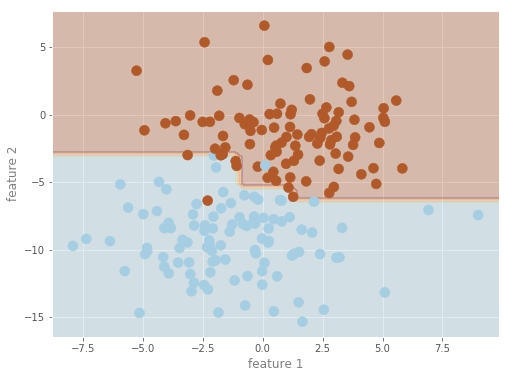

In [266]:
## Decision tree classifier visulization

from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
plt.style.use('ggplot')

X_train, y_train = make_blobs(n_samples=200, centers=2,
                  random_state=2, cluster_std=2.50)
    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlabel('feature 1', color='gray')
ax.set_ylabel('feature 2', color='gray')
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, cmap='Paired', zorder=3)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
    
# create grid to evaluate model
x = np.linspace(xlim[0], xlim[1], 50)
y = np.linspace(ylim[0], ylim[1], 50)
yy, xx = np.meshgrid(y, x)
X_test = np.vstack([xx.ravel(), yy.ravel()]).T

DTC = ClassificationTree()
DTC.fit(X_train, y_train)
zz = DTC.predict(X_test)
zz = zz.reshape(xx.shape)
ax.contourf(xx, yy, zz, cmap='Paired', alpha=0.3, zorder=1)
plt.show()

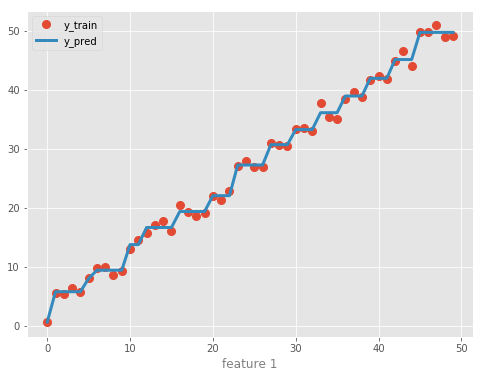

In [287]:
## Decision tree regressor visulization
import random

y = np.array([[i + random.uniform(0, 1)*5 for i in range(50)]]).T
X = np.array([[i for i in range(50)]]).T
X_test = np.array([[i for i in range(50)]]).T

DTR = RegressionTree(max_depth=3)
DTR.fit(X, y)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlabel('feature 1', color='gray')

y_pred = DTR.predict(X_test)
y_pred
ax.plot(X, y, 'o', markersize=8, label="y_train")
ax.plot(X, y_pred, lw=3, label="y_pred")
ax.legend()
plt.show()